In [1]:
import sys, os, re
from typing import *
sys.path = (["../src/", "../"] if re.match(r"^(\w\:\\)|(/)", os.getcwd()) else []) + sys.path
import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.basics import Subtype, Instrument, Signal
from qubx.core.interfaces import IStrategy, IStrategyContext, TriggerEvent
from qubx.core.metrics import tearsheet, chart_signals
from qubx.pandaz.utils import *
import qubx.ta.indicators as ta

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.data.helpers import loader
from qubx.backtester.simulated_data import IteratedDataStreamsSlicer, IterableSimulationData
from qubx.core.mixins.subscription import SubscriptionManager

from qubx.backtester.simulator import simulate, SimulatedTrading, SimulatedExchange, find_instruments_and_exchanges

ld = loader("BINANCE.UM", "1h", source="csv::../tests/data/csv_1h", n_jobs=1)

 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


### Current approach 

In [6]:
class TestA(IStrategy):
    """ Document your strategy here """
    timeframe: str = "15Min"
    exchange = 'BINANCE.UM'

    def on_init(self, ctx: IStrategyContext):
        ctx.set_base_subscription(Subtype.OHLC[self.timeframe])
        ctx.set_event_schedule("55 23 * * *")
        ctx.set_fit_schedule("50 23 * * 1")
        self._idx = 0
        self._to_test = [
            [self.find_instrument(s) for s in ["BTCUSDT", "ETHUSDT"]],
            [self.find_instrument(s) for s in ["BTCUSDT", "BCHUSDT", "LTCUSDT"]],
            [self.find_instrument(s) for s in ["BTCUSDT", "AAVEUSDT", "ETHUSDT"]],
            [self.find_instrument(s) for s in ["BCHUSDT"]],
        ]

    def on_fit(self, ctx: IStrategyContext):
        logger.info(f" -> subscribe : {self.lst(self._to_test[self._idx])}")
        ctx.set_universe(self._to_test[self._idx])
        self._idx += 1
        if self._idx >= len(self._to_test):
            self._idx = 0 

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> Optional[List[Signal]]:
        s = []
        logger.info(f"Trig: {self.lst(ctx.instruments)} --> {str({i.symbol: ctx.quote(i) for i in ctx.instruments})}")
        if 1:
            for i in ctx.instruments:
                data = ctx.ohlc(i, self.timeframe)
                s1 = ta.kama(data.close, 36) - ta.kama(data.close, 12)
                if len(s1) > 1:
                    if s1[1] < 0 and s1[0] > 0:
                        logger.info(f"BUY: {i}")
                        s.append(ctx.instruments[0].signal(+1))

                    if s1[1] > 0 and s1[0] < 0:
                        logger.info(f"SELL: {i}")
                        s.append(i.signal(-1))
        return s

    def find_instrument(self, symbol: str) -> Instrument:
        return lookup.find_symbol(self.exchange, symbol) # type: ignore

    def lst(self, instrs: list[Instrument]):
        return ','.join(map(lambda x: x.symbol, instrs))


In [ ]:
r = simulate(
   # {'A': TestA(timeframe="1h")}, ld, 1000, 
   variate(TestA, timeframe=["15Min", "30Min", "1h"]), ld, 1000, 
   ['BINANCE.UM:BTCUSDT'],
   "vip0_usdt", "2023-07-01", "2023-07-30", debug="DEBUG"
)

,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
0,/TA_(t=15Min),-659.24220,-0.999998,3.041389,-0.574773,106.709664,2215.990000,14.924458,-1.114604,2.524995,0.291326,1328.670529,14.507123,30.51720,4.0
2,/TA_(t=1h),-668.58825,-0.999999,3.020462,-0.590899,106.811806,2220.000000,14.826988,-1.114604,2.536118,0.305066,1330.357952,14.414770,30.68325,4.0
1,/TA_(t=30Min),-27.31788,-0.286085,-3.623893,-0.144373,4.877510,48.775097,-4.355597,-10.472455,0.000000,0.193378,8.682623,-0.091148,1.94288,2.0


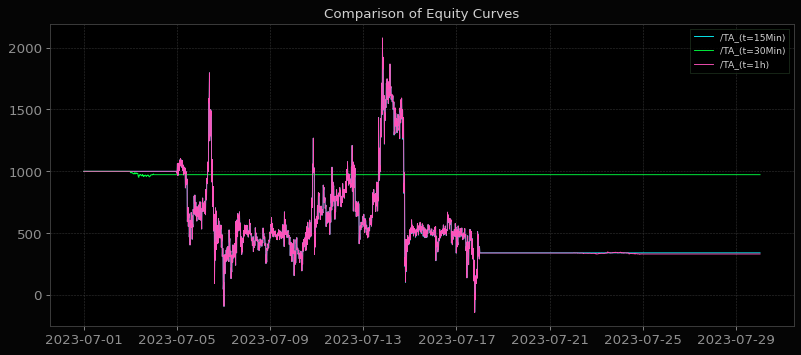

In [18]:
tearsheet(r, False, use_plotly=False)

In [33]:
r[2].config()

"TestA(timeframe='1h', exchange='BINANCE.UM')"

In [ ]:
# chart_signals(r[0], 'BTCUSDT', ld[['BTCUSDT']], show_signals=True)

### - What we want to have -

In [37]:
class TestB(IStrategy):
    timeframe: str = "15Min"

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> Optional[List[Signal]]:
        s = []
        logger.info('Event')
        if 0:
            for i in ctx.instruments:
                data = ctx.ohlc(i, self.timeframe)
                s1 = ta.kama(data.close, 36) - ta.kama(data.close, 12)
                if len(s1) > 1:
                    if s1[1] < 0 and s1[0] > 0:
                        logger.info(f" >> BUY: {i}")
                        s.append(ctx.instruments[0].signal(+1))

                    if s1[1] > 0 and s1[0] < 0:
                        logger.info(f"SELL: {i}")
                        s.append(i.signal(-1))
        return s

In [38]:
r = simulate(
   {'A': TestB(timeframe="1h")}, ld, 1000, 
   ['BINANCE.UM:BTCUSDT'],
   # "vip0_usdt", "2023-06-22", "2023-07-30", debug="DEBUG",
   "vip0_usdt", "2023-07-01", "2023-07-02", debug="DEBUG",

   accurate_stop_orders_execution=True,
   # simulation="ohlc(1h)",
   
)

2023-07-30 00:59:59.000 [🐞] TestB new parameters:
	set timeframe <- 1h


2024-12-09 15:31:32.110 [ 🐞 ] (simulator) 2023-07-01 00:00:00 Initiating simulated trading for binance.um for 1000 x 1.0 in USDT...
2023-07-01 00:00:00.000 [ℹ️] SimulatedTrading emulates stop orders executions at exact price
2023-07-01 00:00:00.000 [ℹ️] SimulatedExchange.binance.um is initialized
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments __all__ -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscriptions None -> []


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(1Min) -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(1Min) -> []
2023-07-01 00:00:00.000 [🐞]  | subscribe: ohlc(1Min) -> {BINANCE.UM:SWAP:BTCUSDT}
2023-07-01 00:00:00.000 [ℹ️] SimulatedExchange ::: Simulation started at 2023-07-01 :::
2023-07-01 00:00:00.000 [🐞] Preloading initial data for ohlc.1Min 2023-07-01 00:00:00 : 2023-07-02 00:00:00 ...
2023-07-01 00:00:01.000 [🐞] Invoking TestB on_fit
2023-07-01 00:00:01.000 [🐞] TestB is fitted
2023-07-01 00:24:00.000 [ℹ️] Event
2023-07-01 00:36:00.000 [ℹ️] Event
2023-07-01 00:59:59.000 [ℹ️] Event
2023-07-01 01:24:00.000 [ℹ️] Event
2023-07-01 01:36:00.000 [ℹ️] Event
2023-07-01 01:59:59.000 [ℹ️] Event
2023-07-01 02:24:00.000 [ℹ️] Event
2023-07-01 02:36:00.000 [ℹ️] Event
2023-07-01 02:59:59.000 [ℹ️] Event
2023-07-01 03:24:00.000 [ℹ️] Event
2023-07-01 03:36:00.000 [ℹ️] Event
2023-07-01 03:59:59.

In [89]:
r[0].config()

"TestB(timeframe='1h')"

In [ ]:
simulate.configs.ON_CLOSE()

In [ ]:
tearsheet(r, False)

In [ ]:
chart_signals(r[0], 'BTCUSDT', ld[['BTCUSDT']], show_signals=True)